In [1]:
from e582utils.data_read import download

import numpy as np
import h5py
import warnings
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import Normalize
import seaborn as sns
from e582lib.modis_chans import chan_dict
from e582lib.channels_reproject import subsample,find_corners
from e582lib.channels_reproject import resample_channels
import pyproj
warnings.filterwarnings("ignore")

In [2]:
myd02file="MYD021KM.A2016224.2100.006.2016225153002.h5"
download(myd02file)
myd03file="MYD03.A2016224.2100.006.2016225152335.h5"
download(myd03file)
%matplotlib inline

trying https://clouds.eos.ubc.ca/~phil/courses/atsc301/downloads/MYD021KM.A2016224.2100.006.2016225153002.h5
writing to: MYD021KM.A2016224.2100.006.2016225153002.h5

MYD021KM.A2016224.2100.006.2016225153002.h5 already exists
and is 159039295 bytes
will not overwrite

trying https://clouds.eos.ubc.ca/~phil/courses/atsc301/downloads/MYD03.A2016224.2100.006.2016225152335.h5
writing to: MYD03.A2016224.2100.006.2016225152335.h5

MYD03.A2016224.2100.006.2016225152335.h5 already exists
and is 40795456 bytes
will not overwrite



In [3]:
def make_xy(ur_row,ll_row,ll_col,ur_col,transform):
    """
    get map coordinates for a slice
    note that row count increases from ur_row to ll_row

    Parameters
    ----------

    ur_row,ll_row,ll_col,ur_col
       slice edges
    transform:
       affine transform for image

    Returns
    -------

    xvals, yvals: ndarrays 
       map coords with shape of [ur_row:ll_row,ll_col:ur_col]
    """
    rownums=np.arange(ur_row,ll_row)
    colnums=np.arange(ll_col,ur_col)
    xline=[]
    yline=[]
    for the_col in colnums:
        x,y = transform*(the_col,0)
        xline.append(x)
    for the_row in rownums:
        x,y= transform*(0,the_row)
        yline.append(y)
    xline,yline=np.array(xline),np.array(yline)
    xvals, yvals = np.meshgrid(xline,yline)
    return xvals,yvals

In [4]:
def make_basemap_xy(ur_row,ll_row,ll_col,ur_col,bmap,transform):
    """
    get map coordinates for a slice including basemap
    easting and northing
    note that row count increases from ur_row to ll_row

    Parameters
    ----------

    ur_row,ll_row,ll_col,ur_col
       slice edges
    bmap: basemap instance
       used to get easting and northing
    transform:
       affine transform for image

    Returns
    -------

    xvals, yvals: ndarrays 
       map coords with shape of [ur_row:ll_row,ll_col:ur_col]
    """
    xvals,yvals=make_xy(ur_row,ll_row,ll_col,ur_col,transform)
    xvals = xvals + bmap.projparams['x_0']
    yvals=yvals + bmap.projparams['y_0']
    return xvals,yvals

In [5]:
def get_corners_centered(numrows,numcols,projection,transform):
    """
    return crnr lats  and lons centered on lon_0,lat_0
    with width numcols and height numrows

    Parameters
    ----------

    numrows: int
       number of rows in slice
    numcols: int
       number of columns in slice
    pyrojection: proj object
       pyproj map project giving lon_0 and lat_0
    transform:
       affine transform for image

    Returns:
       ll_dict: dict
         ll and ur corner lat lons plus lon_0 and lat_0
       xy_dict
         ll and ur corner xy (without basemap easting or northing
       slice_dict
         slices to get columns and rows from original image, xvals and yvals
    """
    cen_col,cen_row = ~transform*(0,0)
    left_col = int(cen_col - numcols/2.)
    right_col = int(cen_col + numcols/2.)
    top_row = int(cen_row - numrows/2.)
    bot_row = int(cen_row + numrows/2.)
    ll_x,ll_y = transform*(left_col,bot_row)
    ur_x,ur_y = transform*(right_col,top_row)
    lon_0,lat_0 = projection(0,0,inverse=True)
    ll_lon,ll_lat = projection(ll_x,ll_y,inverse=True)
    ur_lon,ur_lat = projection(ur_x,ur_y,inverse=True)
    ll_dict=dict(llcrnrlat=ll_lat,llcrnrlon=ll_lon,urcrnrlat=ur_lat,
                  urcrnrlon=ur_lon,lon_0=lon_0,lat_0=lat_0)
    xy_dict = dict(ll_x=ll_x,ll_y=ll_y,ur_x=ur_x,ur_y=ur_y)
    slice_dict=dict(row_slice=slice(top_row,bot_row),col_slice=slice(left_col,right_col))
    return ll_dict,xy_dict,slice_dict


In [6]:
def get_corners(ur_row,ll_row,ll_col,ur_col,projection,transform):
    """
    return crnr lats  for a box with the contiguous
    rows in between ur_row and ll_row and columns between ll_col and
    ur_col
    Note that rowlist increases downward, so toprow is rowlist[0]

    Parameters
    ----------

    ur_row,ll_row,ll_col,ur_col
       slice edges
    pyrojection: proj object
       pyproj map project giving lon_0 and lat_0
    transform:
       affine transform for image

    Returns:
       ll_dict: dict
         ll and ur corner lat lons plus lon_0 and lat_0
       xy_dict
         ll and ur corner xy (without basemap easting or northing
       slice_dict
         slices to get columns and rows from original image, xvals and yvals
    """
    ll_x,ll_y = transform*(ll_col,ll_row)
    ur_x,ur_y = transform*(ur_col,ur_row)
    lon_0,lat_0 = projection(0,0,inverse=True)
    ll_lon,ll_lat = projection(ll_x,ll_y,inverse=True)
    ur_lon,ur_lat = projection(ur_x,ur_y,inverse=True)
    ll_dict=dict(llcrnrlat=ll_lat,llcrnrlon=ll_lon,urcrnrlat=ur_lat,
                  urcrnrlon=ur_lon,lon_0=lon_0,lat_0=lat_0)
    xy_dict = dict(ll_x=ll_x,ll_y=ll_y,ur_x=ur_x,ur_y=ur_y)
    slice_dict=dict(row_slice=slice(ur_row,ll_row),col_slice=slice(ll_col,ur_col))
    return ll_dict,xy_dict,slice_dict

In [7]:
chan_list=['1','2','3','4']
reflectivity_list=[]
for the_chan in chan_list:
    #
    # read channel channels
    #
    index = chan_dict[the_chan]['index']
    field_name = chan_dict[the_chan]['field_name']
    scale_name = chan_dict[the_chan]['scale']
    offset_name = chan_dict[the_chan]['offset']
    with h5py.File(myd02file, 'r') as h5_file:
        chan = h5_file['MODIS_SWATH_Type_L1B']['Data Fields'][field_name][
            index, :, :]
        scale = h5_file['MODIS_SWATH_Type_L1B']['Data Fields'][
            field_name].attrs[scale_name][...]
        offset = h5_file['MODIS_SWATH_Type_L1B']['Data Fields'][
            field_name].attrs[offset_name][...]
        chan_calibrated = (chan - offset[index]) * scale[index]
        chan_calibrated = chan_calibrated.astype(
            np.float32)  #convert from 64 bit to 32bit to save space
        reflectivity_list.append(chan_calibrated)

with h5py.File(myd03file) as geo_file:
        lon_data = geo_file['MODIS_Swath_Type_GEO']['Geolocation Fields'][
            'Longitude'][...]
        lat_data = geo_file['MODIS_Swath_Type_GEO']['Geolocation Fields'][
            'Latitude'][...]

In [8]:
llcrnr=dict(lat=45,lon= -125)
urcrnr=dict(lat=50,lon= -120)
subsample_list=subsample(*reflectivity_list,lats=lat_data,lons=lon_data,llcrnr=llcrnr,urcrnr=urcrnr)
lats,lons=subsample_list[:2]
numchans=len(subsample_list) -2
rows,cols=lats.shape
chan_array=np.empty([rows,cols,numchans],dtype=np.float32)
for chan in range(numchans):
    chan_array[:,:,chan]=subsample_list[chan+2]

In [9]:
corner_dict=find_corners(subsample_list[0],subsample_list[1])
corner_dict

{'lat_0': 47.459999084472656,
 'lat_list': [44.227749, 50.692249],
 'llcrnrlat': 44.227749,
 'llcrnrlon': -127.23767,
 'lon_0': -122.78046417236328,
 'lon_list': [-127.23767, -118.32326],
 'urcrnrlat': 50.692249,
 'urcrnrlon': -118.32326}

In [10]:
chan_list=['1','2','3','4']
result_dict= resample_channels(chan_array,lats,lons,corner_dict)
#
# add ndvi as a new layer so that channels
# grows to shape= rows x cols x 5
# 
channels=result_dict['channels']
ch1=channels[:,:,0]
ch2=channels[:,:,1]
ndvi=(ch2 - ch1)/(ch2 + ch1)
result_dict.keys()

pyresample area_def information:

dump area definition:
Area ID: granule
Name: modis swath 5min granule
Projection ID: laea
Projection: {'datum': 'WGS84', 'lat_0': '47.4599990844727', 'lon_0': '-122.7804641723633', 'proj': 'laea', 'units': 'm'}
Number of columns: 516
Number of rows: 552
Area extent: (-356016.46290260204, -349178.12992515496, 314880.87185323943, 368521.51227908855)


x and y pixel dimensions in meters:
1300.1886332477548
1300.1805112395714

completed channels_resample


dict_keys(['basemap_args', 'geotiff_args', 'fill_value', 'channels', 'area_def_args'])

In [11]:
from affine import Affine
geotiff_args = result_dict['geotiff_args']
transform = Affine.from_gdal(*geotiff_args['adfgeotransform'])
basemap_args=result_dict['basemap_args']
fill_value=result_dict['fill_value']
proj_keys={'lon_0','lat_0'}
projection_dict={k:basemap_args[k] for k in proj_keys}
projection_dict['datum']='WGS84'
projection_dict['proj'] = 'laea'
projection=pyproj.Proj(projection_dict)

In [12]:
basemap_args

{'ellps': 'WGS84',
 'lat_0': 47.459999084472656,
 'llcrnrlat': 44.22774886587065,
 'llcrnrlon': -127.23767089843751,
 'lon_0': -122.78046417236328,
 'projection': 'laea',
 'urcrnrlat': 50.69224929516728,
 'urcrnrlon': -118.32325744628906}

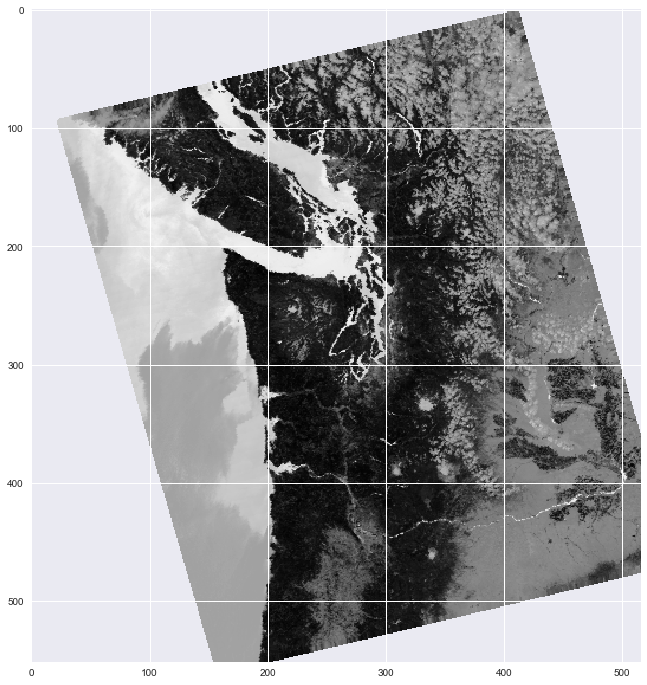

In [13]:
plt.close('all')
fig,ax=plt.subplots(1,1,figsize=(12,12))
ax.imshow(ndvi);

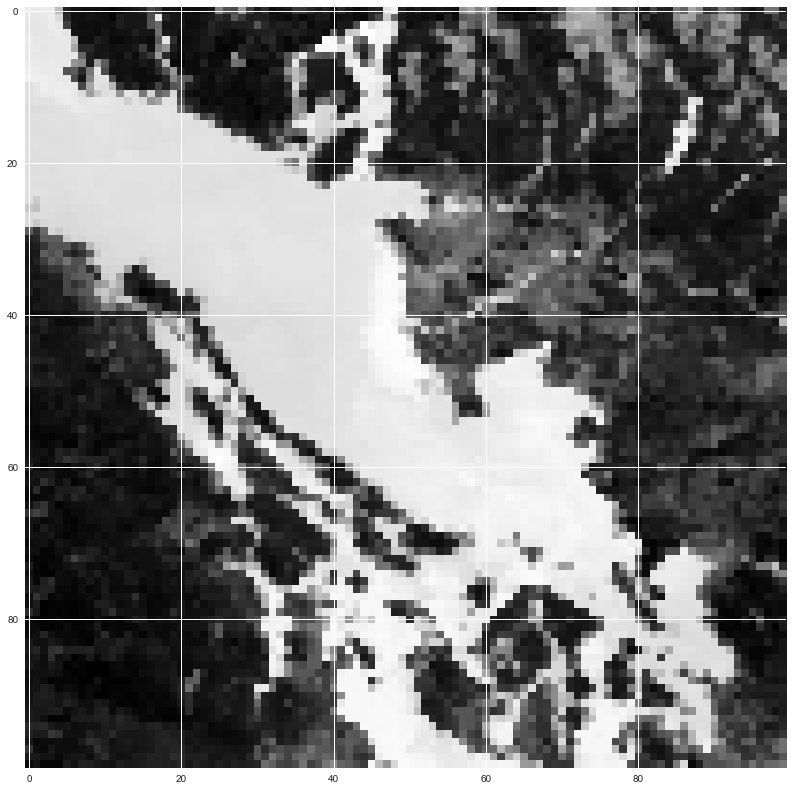

In [14]:
fig, ax = plt.subplots(1,1,figsize=(14,14))
ll_col=200
ll_row=200
ur_col=300
ur_row=100
ndvi_zoom=ndvi[ur_row:ll_row,ll_col:ur_col]
ax.imshow(ndvi_zoom);

In [15]:
cmap=sns.diverging_palette(261, 153,sep=6, s=85, l=66,as_cmap=True)
vmin= -0.9
vmax=  0.9
cmap.set_over('c')
cmap.set_under('k',alpha=0.8)
cmap.set_bad('k',alpha=0.1)
the_norm=Normalize(vmin=vmin,vmax=vmax,clip=False)

### Plot slice with basemap

Step 1, get the lat/lon corners for a 100 x 100 slice centered on lon_0, lat_0
and create a basemap instance with those corners

In [24]:
ll_keys=['llcrnrlat','llcrnrlon','urcrnrlat','urcrnrlon']
[basemap_args.pop(key,None) for key in ll_keys]
basemap_args

{'ax': <matplotlib.axes._subplots.AxesSubplot at 0x104fe1128>,
 'ellps': 'WGS84',
 'lat_0': 47.4599990845,
 'lon_0': -122.780464172,
 'projection': 'laea',
 'resolution': 'c'}

In [36]:
ll_dict,xy_dict,slice_dict=get_corners_centered(100,100,projection,transform)
new_basemap_args=dict(basemap_args)
width=xy_dict['ur_x'] - xy_dict['ll_x']
height=xy_dict['ur_y']-xy_dict['ll_y']
new_basemap_args['width']=width
new_basemap_args['height']=height
# new_basemap_args.update(ll_dict)
# bmap = Basemap(**new_basemap_args)
bmap_xy = Basemap(**new_basemap_args)
bmap_xy.llcrnrx,bmap_xy.llcrnry,bmap_xy.urcrnrx,bmap_xy.urcrnry

(0.0, 0.0, 130018.86333420788, 130018.05116509624)

In [35]:
ll_dict,xy_dict,slice_dict=get_corners_centered(100,100,projection,transform)
new_basemap_args=dict(basemap_args)
new_basemap_args.update(ll_dict)
bmap_ll = Basemap(**new_basemap_args)
import pdir
bmap_ll.llcrnrx,bmap_ll.llcrnry,bmap_ll.urcrnrx,bmap_ll.urcrnry

(0.0, 0.0, 130018.86333420889, 130018.05116508837)

#### Step 2

make x,y arrays that cover every pixel in the remapped ndvi image

In [37]:
nrows,ncols=ndvi.shape
ur_row=0
ll_row=nrows
ll_col=0
ur_col=ncols
xvals,yvals = make_basemap_xy(ur_row,ll_row,ll_col,ur_col,bmap_xy,transform)

#### Step 3

slice the xvals,yvals and ndvi array to the 100 x 100 pixel selection
and make the map of of the slices

{'ax': <matplotlib.axes._subplots.AxesSubplot at 0x104feee10>,
 'ellps': 'WGS84',
 'lat_0': 47.4599990845,
 'llcrnrlat': 46.87708665892727,
 'llcrnrlon': -123.64725842276093,
 'lon_0': -122.780464172,
 'projection': 'laea',
 'resolution': 'h',
 'urcrnrlat': 48.04665580407348,
 'urcrnrlon': -121.92281730077711}

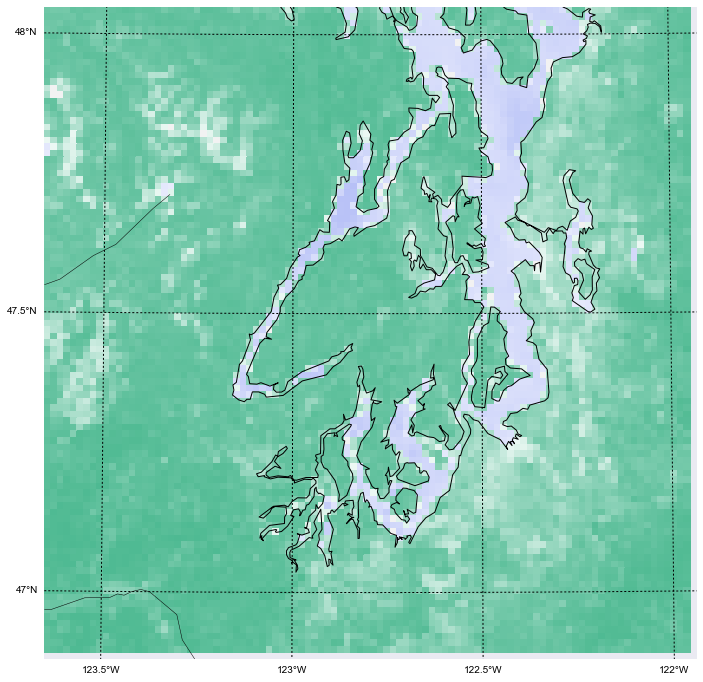

In [18]:
row_slice,col_slice=slice_dict['row_slice'],slice_dict['col_slice']
xvals_s,yvals_s,ndvi_s = xvals[row_slice,col_slice],yvals[row_slice,col_slice],ndvi[row_slice,col_slice]
fig, ax = plt.subplots(1,1,figsize=(12,12))
new_basemap_args['ax']=ax
new_basemap_args['resolution'] = 'h'
bmap = Basemap(**new_basemap_args)
col=bmap.pcolormesh(xvals_s,yvals_s,ndvi_s,cmap=cmap,norm=the_norm)
lat_sep,lon_sep= 0.5, 0.5
parallels = np.arange(46, 51, lat_sep)
meridians = np.arange(-125,-121, lon_sep)
bmap.drawparallels(parallels, labels=[1, 0, 0, 0],
                        fontsize=10, latmax=90)
bmap.drawmeridians(meridians, labels=[0, 0, 0, 1],
                       fontsize=10, latmax=90);
bmap.drawcoastlines();
bmap.drawrivers();
new_basemap_args

### Repeat with an arbitray slice that is off the lon_0, lat_0 center

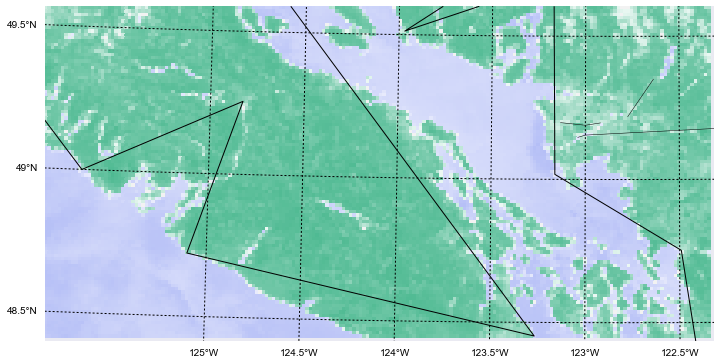

In [19]:
ll_col=100
ll_row=200
ur_col=300
ur_row=100
fig,ax = plt.subplots(1,1,figsize=(12,12))
ll_dict,xy_dict,slice_dict=get_corners(ur_row,ll_row,ll_col,ur_col,projection,transform)
basemap_args.update(ll_dict)
basemap_args['ax'] = ax
basemap_args['resolution'] = 'c'
bmap = Basemap(**basemap_args)
height,width=ndvi.shape
ur_row=0
ll_row=height
ll_col=0
ur_col=width
xvals,yvals = make_basemap_xy(ur_row,ll_row,ll_col,ur_col,bmap,transform)
row_slice,col_slice=slice_dict['row_slice'],slice_dict['col_slice']
xvals_s,yvals_s,ndvi_s = xvals[row_slice,col_slice],yvals[row_slice,col_slice],ndvi[row_slice,col_slice]
col=bmap.pcolormesh(xvals_s,yvals_s,ndvi_s,cmap=cmap,norm=the_norm)
lat_sep,lon_sep= 0.5, 0.5
parallels = np.arange(46, 51, lat_sep)
meridians = np.arange(-125,-121, lon_sep)
bmap.drawparallels(parallels, labels=[1, 0, 0, 0],
                        fontsize=10, latmax=90)
bmap.drawmeridians(meridians, labels=[0, 0, 0, 1],
                       fontsize=10, latmax=90);
bmap.drawcoastlines();
bmap.drawrivers();

In [20]:
basemap_args

{'ax': <matplotlib.axes._subplots.AxesSubplot at 0x104fe1128>,
 'ellps': 'WGS84',
 'lat_0': 47.4599990845,
 'llcrnrlat': 48.39577183309575,
 'llcrnrlon': -125.83310683724659,
 'lon_0': -122.780464172,
 'projection': 'laea',
 'resolution': 'c',
 'urcrnrlat': 49.604039896676134,
 'urcrnrlon': -122.30963330421527}